# Connect to DuckDB

This cell establishes a connection to the DuckDB database file `sakila.duckdb` so we can query the data. The connection uses a relative path from the `notebooks/` folder.


In [68]:
import duckdb
import pandas as pd

con = duckdb.connect("../data/sakila.duckdb")


### Preview Staging Tables

This cell shows all tables in the `staging` schema and previews the first 5 rows of the `actor` table.


In [69]:
tables = con.execute("SHOW TABLES").fetchall()
staging_tables = con.execute(
    "SELECT table_name FROM information_schema.tables WHERE table_schema='staging'"
).fetchall()
print("Tables in staging schema:", staging_tables)

Tables in staging schema: [('actor',), ('address',), ('category',), ('city',), ('country',), ('customer',), ('film',), ('film_actor',), ('film_category',), ('inventory',), ('language',), ('payment',), ('rental',), ('staff',), ('store',), ('_dlt_loads',), ('_dlt_pipeline_state',), ('_dlt_version',)]


### first 5 rows
This code shows first 5 rows of the table actor where we can see 

In [70]:

sample_data = con.execute("SELECT * FROM staging.actor LIMIT 5").fetchdf()
sample_data


,actor_id,first_name,last_name,last_update,_dlt_load_id,_dlt_id
0,1.0,PENELOPE,GUINESS,2021-03-06 15:51:59,1765206049.4797397,/n6D5pphutgN6g
1,2.0,NICK,WAHLBERG,2021-03-06 15:51:59,1765206049.4797397,vYtmfzoPJ99Pzg
2,3.0,ED,CHASE,2021-03-06 15:51:59,1765206049.4797397,CM6qcu0U+Apl4w
3,4.0,JENNIFER,DAVIS,2021-03-06 15:51:59,1765206049.4797397,SlvWobGEuMou6g
4,5.0,JOHNNY,LOLLOBRIGIDA,2021-03-06 15:51:59,1765206049.4797397,jRE9Gm1dmLgtBQ


### 1a Identify Movies Longer Than 3 Hours

Objective: Find all movies with a duration greater than 180 minutes and display their title and length.

In [71]:
long_movies = con.execute("""
    SELECT title, length 
    FROM staging.film 
    WHERE length > 180
""").df()
long_movies


,title,length
0,ANALYZE HOOSIERS,181
1,BAKED CLEOPATRA,182
2,CATCH AMISTAD,183
3,CHICAGO NORTH,185
4,CONSPIRACY SPIRIT,184
5,CONTROL ANTHEM,185
6,CRYSTAL BREAKING,184
7,DARN FORRESTER,185
8,FRONTIER CABIN,183
9,GANGS PRIDE,185


### 1b Movies Containing the Word “Love” in the Title

Objective: List movies whose titles contain “love” along with their rating, length, and description.

In [72]:
love_movies = con.execute("""
    SELECT title, rating, length, 
    FROM staging.film
    WHERE title ILIKE '%love%'
""").df()

love_movies

,title,rating,length
0,GRAFFITI LOVE,PG,117
1,IDAHO LOVE,PG-13,172
2,IDENTITY LOVER,PG-13,119
3,INDIAN LOVE,NC-17,135
4,LAWRENCE LOVE,NC-17,175
5,LOVE SUICIDES,R,181
6,LOVELY JINGLE,PG,65
7,LOVER TRUMAN,G,75
8,LOVERBOY ATTACKS,PG-13,162
9,STRANGELOVE DESIRE,NC-17,103


### 1c) Descriptive Statistics of Movie Length

Objective: Compute summary statistics for the length column, including the shortest, longest, average, and median movie lengths.

In [73]:
length_stats = con.execute("""
    SELECT
        MIN(length) AS shortest,
        AVG(length) AS average,
        MEDIAN(length) AS median,
        MAX(length) AS longest
    FROM staging.film
""").df()

length_stats


,shortest,average,median,longest
0,46,115.272,114.0,185


### 1d) Top 10 Most Expensive Movies to Rent Per Day

Objective: Determine the movies with the highest rental rate per day.

In [ ]:
expensive_movies = con.execute("""
    SELECT title, rental_rate, rental_duration, (rental_rate / rental_duration) AS cost_per_day
    FROM staging.film
    ORDER By cost_per_day DESC
    LIMIT 10
""").df()
expensive_movies

### 1e Top 10 Actors by Number of Movies

Objective: Identify the actors who have appeared in the most films.

In [74]:
top_actors = con.execute("""
    SELECT a.first_name, a.last_name, COUNT(fa.film_id) AS movie_count
    FROM staging.actor a
    JOIN staging.film_actor fa ON a.actor_id = fa.actor_id
    GROUP BY a.actor_id, a.first_name, a.last_name
    ORDER BY movie_count DESC
    LIMIT 10
""").df()

top_actors
                         
                         
                         
               



,first_name,last_name,movie_count
0,GINA,DEGENERES,42
1,WALTER,TORN,41
2,MARY,KEITEL,40
3,MATTHEW,CARREY,39
4,SANDRA,KILMER,37
5,SCARLETT,DAMON,36
6,VAL,BOLGER,35
7,HENRY,BERRY,35
8,GROUCHO,DUNST,35
9,UMA,WOOD,35


### **Custom Question 1: Which film has the highest replacement cost?**

**Objective:**  
Identify the film with the highest *replacement cost*, which indicates the most expensive movie to replace in the inventory.

**Explanation:**  
The `replacement_cost` column represents how much it costs the store to replace a lost or damaged film. Finding the highest value helps the business understand which films are most valuable.

**Query:**


In [75]:
highest_replacement = con.execute("""
    SELECT title, replacement_cost
    FROM staging.film
    ORDER BY replacement_cost DESC
    LIMIT 1
""").df()

highest_replacement

,title,replacement_cost
0,ARABIA DOGMA,29.99


### **Custom Question 2: How many customers do we have in each city?**

**Objective:**  
Understand how the customer base is distributed across cities.

**Explanation:**  
This helps reveal where most of the customers live. Cities with higher customer counts may need more marketing focus, promotions, or store attention.

**Query:**


In [76]:
customers_by_city = con.execute("""
    SELECT ci.city, COUNT(c.customer_id) AS customer_count
    FROM staging.customer c
    JOIN staging.address a ON c.address_id = a.address_id
    JOIN staging.city ci ON a.city_id = ci.city_id
    GROUP BY ci.city
    ORDER BY customer_count DESC
""").df()

customers_by_city


,city,customer_count
0,Aurora,2
1,London,2
2,Adana,1
3,Antofagasta,1
4,Baicheng,1
...,...,...
592,Tartu,1
593,Xinxiang,1
594,Yangor,1
595,Zaoyang,1


### **Custom Question 3: What is the average rental duration for each film rating?**

**Objective:**  
Compare the average number of days customers keep movies with different MPAA ratings (G, PG, PG-13, R, NC-17).

**Explanation:**  
This helps reveal whether certain types of movies tend to be rented for longer periods (for example, family movies vs. adult-rated movies).

**Query:**


In [77]:
avg_rental_duration = con.execute("""
    SELECT rating, AVG(rental_duration) AS avg_duration
    FROM staging.film
    GROUP BY rating
    ORDER BY avg_duration DESC
""").df()

avg_rental_duration


,rating,avg_duration
0,NC-17,5.142857
1,PG,5.082474
2,PG-13,5.053812
3,G,4.837079
4,R,4.774359


### **Task 2(a): Top 5 Customers by Total Spend**

**Objective:**  
Identify the five customers who have spent the most money in total. This helps the business recognize its top customers and potentially reward them with discounts or special offers.

**Explanation:**  
We aggregate all payments made by each customer, calculate their total spend, then visualize the top 5 customers in a bar chart.


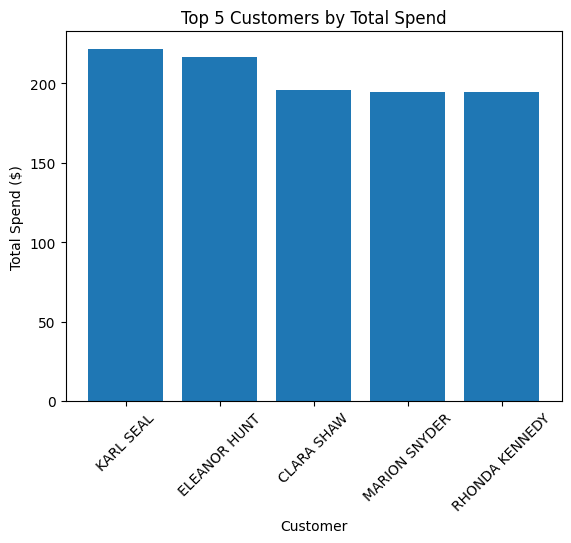

In [78]:
import matplotlib.pyplot as plt

top_customers = con.execute("""
    SELECT c.first_name || ' ' || c.last_name AS customer_name,
           SUM(p.amount) AS total_spend
    FROM staging.payment p
    JOIN staging.customer c ON p.customer_id = c.customer_id
    GROUP BY customer_name
    ORDER BY total_spend DESC
    LIMIT 5
""").df()

# Plot
plt.bar(top_customers['customer_name'], top_customers['total_spend'])
plt.xlabel("Customer")
plt.ylabel("Total Spend ($)")
plt.title("Top 5 Customers by Total Spend")
plt.xticks(rotation=45)
plt.show()


### **Task 2(b): Total Revenue by Film Category**

**Objective:**  
Determine how much revenue each movie category generates.

**Explanation:**  
By linking payment, rental, inventory, film, and category tables, we can calculate the total revenue for each film category.  
This bar chart shows which categories are most profitable, helping the business understand where demand is highest.


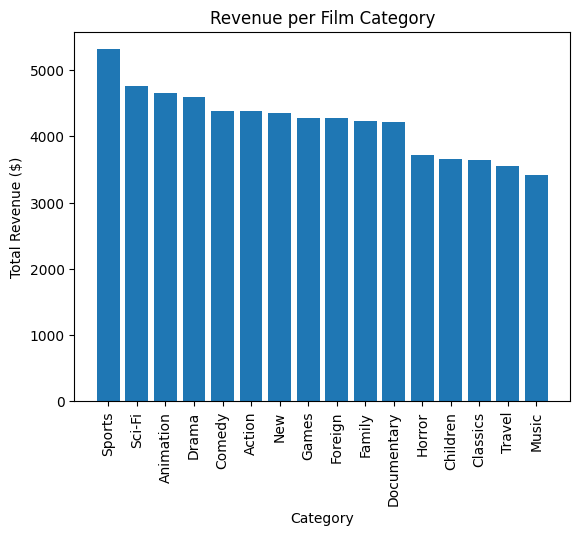

In [79]:
category_revenue = con.execute("""
    SELECT c.name AS category,
           SUM(p.amount) AS total_revenue
    FROM staging.payment p
    JOIN staging.rental r ON p.rental_id = r.rental_id
    JOIN staging.inventory i ON r.inventory_id = i.inventory_id
    JOIN staging.film f ON i.film_id = f.film_id
    JOIN staging.film_category fc ON f.film_id = fc.film_id
    JOIN staging.category c ON fc.category_id = c.category_id
    GROUP BY c.name
    ORDER BY total_revenue DESC
""").df()

plt.bar(category_revenue['category'], category_revenue['total_revenue'])
plt.xlabel("Category")
plt.ylabel("Total Revenue ($)")
plt.title("Revenue per Film Category")
plt.xticks(rotation=90)
plt.show()
